## Notebook 3 - Model Benchmark & Selection  

This notebook compares a suite of machine‑learning algorithms for predicting
gold prospectivity in the Tapajós Mineral Province.  
Building on the exploratory insights from the **Exploratory Data Analysis Notebook** we did:

1. apply the data‑driven preprocessing pipeline  
   * one-hot‑encoding for *Lithology*  
   * log/robust transforms for skewed & heavy‑tailed bands  
2. perform a strict **spatial block split** (5 km) to avoid leakage;  
3. train ten candidate models with class‑imbalance awareness;  
4. evaluate them on an **independent test block set** using six metrics  
   emphasising **Matthews Correlation Coefficient (MCC)**.

The outcome of this benchmark is the **XGBoost (XGB) classifier** presented the highest MCC, which we will carry forward to **Notebook 4** for threshold
optimisation and prospectivity‑map generation.

Author: João Paulo Alves - joao dot guilherme dot alves @ usp dot br

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# core scientific stack
!pip install geopandas rasterio category_encoders -q
# GPU-enabled learners
!pip install xgboost -q                       # XGB
!pip install catboost -q                      # CatBoost
!pip install --extra-index-url=https://pypi.nvidia.com cuml-cu12 -q  # RAPIDS / cuML
!pip install lightgbm -q                      # LightGBM

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 22.2/22.2 MB 70.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.7/85.7 kB 7.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.2/99.2 MB 25.4 MB/s eta 0:00:00


In [ ]:
import os, warnings, numpy as np, pandas as pd, geopandas as gpd, rasterio
import matplotlib.pyplot as plt
from rasterio.features import rasterize

from collections import Counter
from sklearn.model_selection import (train_test_split,
                                     GroupKFold,
                                     StratifiedGroupKFold,
                                     RandomizedSearchCV)
from sklearn.metrics import (accuracy_score, precision_score, recall_score,
                             f1_score, matthews_corrcoef, make_scorer)
from scipy.stats import randint, uniform, loguniform

from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, RobustScaler, StandardScaler, FunctionTransformer
from sklearn.impute import SimpleImputer
import re, unicodedata

# GPU-accelerated libraries
from xgboost              import XGBClassifier
from catboost             import CatBoostClassifier
from lightgbm import LGBMClassifier

from cuml.ensemble        import RandomForestClassifier  as cuRFClassifier
from cuml.linear_model    import LogisticRegression     as cuLogisticRegression
from cuml.neighbors       import KNeighborsClassifier   as cuKNNClassifier

warnings.filterwarnings("ignore")

In [ ]:
RASTER_DIR       = "/content/drive/MyDrive/OrePredictionProject/data/raster_data"
OCC_GPKG         = "/content/drive/MyDrive/OrePredictionProject/data/vector_data/GoldDeposits.gpkg"
FIGS_DIR         = "/content/drive/MyDrive/OrePredictionProject/figures"
BUFFER_DIST_M    = 0.045
BLOCK_SPACING    = 0.045
TEST_BLOCK_FRAC  = 0.30
RANDOM_STATE     = 42

In [ ]:
def load_stack(folder):
    arrs, names, tr, bounds = [], [], None, None
    for fn in sorted(f for f in os.listdir(folder) if f.endswith(".tif")):
        with rasterio.open(os.path.join(folder, fn)) as src:
            a = src.read(1).astype(np.float32)
            a[a == src.nodata] = np.nan
            arrs.append(a)
            names.append(fn.replace(".tif", ""))
            if tr is None:
                tr, bounds = src.transform, src.bounds
    return np.stack(arrs), names, tr, bounds

In [ ]:
stack, layer_names, transform, bounds = load_stack(RASTER_DIR)
print("Raster stack:", stack.shape, "layers:", layer_names)

Raster stack: (12, 693, 807) layers: ['1VD', 'BouguerAnom', 'Elev', 'Lithology', 'Magnetom', 'PotEq', 'TernaryComp', 'ThEq', 'ThKRatio', 'TotGrad', 'TotalCount', 'UEq']


In [ ]:
gdf = gpd.read_file(OCC_GPKG)
shapes = ((geom.buffer(BUFFER_DIST_M), 1) for geom in gdf.geometry)
labels = rasterize(shapes, out_shape=stack[0].shape,
                   fill=0, transform=transform).astype(np.float32)
labels[np.any(np.isnan(stack), 0)] = np.nan

In [ ]:
n_layers, R, C = stack.shape
X_flat = stack.reshape(n_layers, -1).T
y_flat = labels.ravel()

In [ ]:
mask = ~np.isnan(y_flat)
for i in range(n_layers):
    mask &= ~np.isnan(X_flat[:, i])

In [ ]:
X_valid, y_valid = X_flat[mask], y_flat[mask].astype(int)

In [ ]:
# pixel coordinates for spatial split
rows, cols = np.indices((R, C))
xs, ys = rasterio.transform.xy(transform, rows, cols)
xs = np.asarray(xs).ravel()[mask]
ys = np.asarray(ys).ravel()[mask]

In [ ]:
print(f"Pixels kept: {len(X_valid)}  –  positives: {y_valid.sum()}")

Pixels kept: 355509  –  positives: 54849


In [ ]:
def assign_blocks(x, y, spacing):
    x0, y0 = x.min(), y.min()
    bx = np.floor((x - x0) / spacing).astype(int)
    by = np.floor((y - y0) / spacing).astype(int)
    return bx + by * (bx.max() + 1)

In [ ]:
block_lbl = assign_blocks(xs, ys, BLOCK_SPACING)

train_blocks, test_blocks = train_test_split(np.unique(block_lbl),
                                             test_size=TEST_BLOCK_FRAC,
                                             random_state=RANDOM_STATE)
train_mask = np.isin(block_lbl, train_blocks)
test_mask  = ~train_mask

X_train_raw, y_train = X_valid[train_mask], y_valid[train_mask]
X_test_raw , y_test  = X_valid[test_mask] , y_valid[test_mask]

print("Train:", X_train_raw.shape, "  Test:", X_test_raw.shape)

Train: (248832, 12)   Test: (106677, 12)


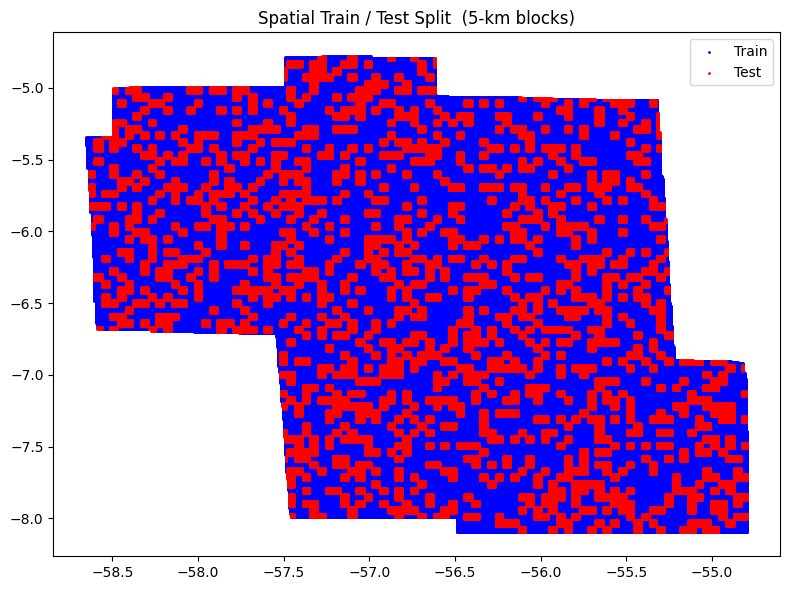

In [ ]:
# Plot train/test split
plt.figure(figsize=(8,6))
plt.scatter(xs[train_mask], ys[train_mask], s=1, c='blue', label='Train')
plt.scatter(xs[test_mask] , ys[test_mask] , s=1, c='red',  label='Test')
plt.title("Spatial Train / Test Split  (5‑km blocks)")
plt.legend(); plt.tight_layout(); plt.show()

In [ ]:
gkf = StratifiedGroupKFold(n_splits=3, shuffle=True, random_state=RANDOM_STATE)
folds = list(gkf.split(X_train_raw, y_train, groups=block_lbl[train_mask]))

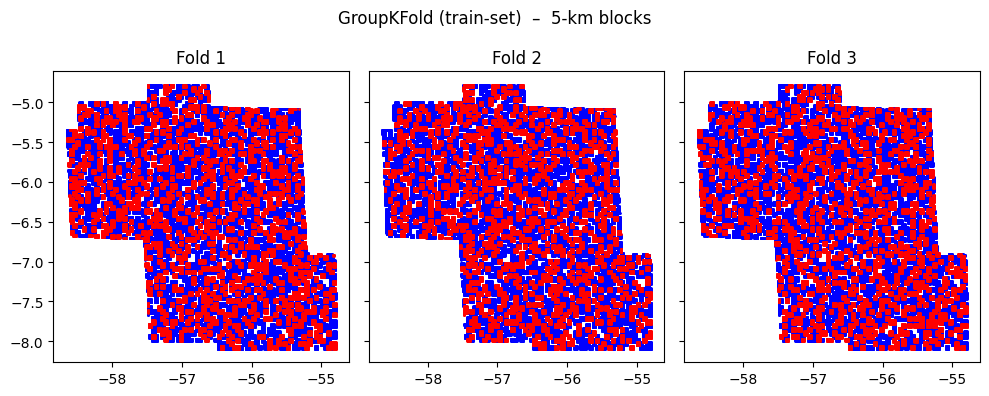

In [ ]:
fig, axs = plt.subplots(1,3, figsize=(10,4), sharex=True, sharey=True)
for i,(tr,te) in enumerate(folds):
    axs[i].scatter(xs[train_mask][tr], ys[train_mask][tr], s=1, c='blue')
    axs[i].scatter(xs[train_mask][te], ys[train_mask][te], s=1, c='red')
    axs[i].set_title(f"Fold {i+1}")
plt.suptitle("GroupKFold (train‑set)  –  5‑km blocks"); plt.tight_layout(); plt.show()

In [ ]:
def slug(s: str) -> str:
    s = unicodedata.normalize("NFKD", s).encode("ascii", "ignore").decode()
    return re.sub(r"[^a-z0-9]", "", s.lower())

slugs = [slug(n) for n in layer_names]

In [ ]:
def idx_contains(*kw):
    kw = [slug(k) for k in kw]
    return [i for i, s in enumerate(slugs) if any(k in s for k in kw)]

In [ ]:
cat_idx     = idx_contains("lithology")
skewed_idx  = idx_contains("ueq", "poteq", "theq", "totalcount", "totgrad")
outlier_idx = idx_contains("bougueranom", "magnetom", "1vd")
tenary_idx  = idx_contains("ternarycomp")

In [ ]:
assigned       = set(cat_idx + skewed_idx + outlier_idx + tenary_idx)
other_num_idx  = [i for i in range(len(layer_names)) if i not in assigned]

In [ ]:
print("Categorical idx :", cat_idx)
print("Skewed idx      :", skewed_idx)
print("Outlier idx     :", outlier_idx)
print("Tenary idx      :", tenary_idx)
print("Other numeric   :", other_num_idx)

Categorical idx : [3]
Skewed idx      : [5, 7, 9, 10, 11]
Outlier idx     : [0, 1, 4]
Tenary idx      : [6]
Other numeric   : [2, 8]


In [ ]:
log_tf = FunctionTransformer(np.log1p, validate=False)

pipe_cat     = Pipeline([("imp", SimpleImputer(strategy="most_frequent")),
                         ("ohe", OneHotEncoder(handle_unknown="ignore",
                                               sparse_output=False))])

pipe_skewed  = Pipeline([("imp", SimpleImputer(strategy="median")),
                         ("log", log_tf),
                         ("sc" , StandardScaler())])

pipe_outlier = Pipeline([("imp", SimpleImputer(strategy="median")),
                         ("sc" , RobustScaler())])

pipe_tenary  = Pipeline([("imp", SimpleImputer(strategy="median")),
                         ("sc" , StandardScaler())])

pipe_other   = Pipeline([("imp", SimpleImputer(strategy="median")),
                         ("sc" , StandardScaler())])

In [ ]:
preproc = ColumnTransformer([
    ("cat"    , pipe_cat    , cat_idx),
    ("skewed" , pipe_skewed , skewed_idx),
    ("outlier", pipe_outlier, outlier_idx),
    ("tenary" , pipe_tenary , tenary_idx),
    ("other"  , pipe_other  , other_num_idx)
])

In [ ]:
def metrics(y_true, y_pred):
    acc  = accuracy_score(y_true, y_pred)
    prec = precision_score(y_true, y_pred, zero_division=0)
    rec  = recall_score(y_true, y_pred, zero_division=0)
    f1   = f1_score(y_true, y_pred, zero_division=0)
    mcc  = matthews_corrcoef(y_true, y_pred)
    specificity = recall_score(y_true, y_pred, pos_label=0, zero_division=0)
    gmean = np.sqrt(rec * specificity) if rec * specificity >= 0 else 0
    return acc, prec, rec, f1, mcc, gmean

In [ ]:
scale_pos = Counter(y_train)[0] / Counter(y_train)[1]
print(f"Scale Pos Weight: {scale_pos}")

Scale Pos Weight: 5.596643779327165


In [ ]:
cu_defaults = dict(
    random_state = RANDOM_STATE,
    verbose      = 0
)

models = {
    # native GPU
    "XGB": XGBClassifier(
        n_estimators=300, max_depth=6, learning_rate=0.1,
        subsample=0.8, colsample_bytree=1.0,
        scale_pos_weight=scale_pos,
        eval_metric="logloss", use_label_encoder=False,
        random_state=RANDOM_STATE,
        tree_method="gpu_hist", gpu_id=0
    ),

    "CatBoost": CatBoostClassifier(
        depth=6, learning_rate=0.1,
        scale_pos_weight=scale_pos,
        random_state=RANDOM_STATE,
        verbose=0, task_type="GPU", devices="0"
    ),

    "LGBM": LGBMClassifier(
        device_type="gpu",
        n_estimators=300,
        max_depth=-1,
        scale_pos_weight=scale_pos,
        random_state=RANDOM_STATE
    ),

    # cuML learners
    "cuRF"  : cuRFClassifier(n_estimators=400,
                             **cu_defaults),

    "cuLogReg": cuLogisticRegression(max_iter=1000,
                                     fit_intercept=True,
                                     **cu_defaults),

    "cuKNN" : cuKNNClassifier(n_neighbors=15,
                              metric = "minkowski",
                              p = 2,
                              **cu_defaults),
}

[2025-07-01 20:28:04.395] [CUML] [info] Unused keyword parameter: random_state during cuML estimator initialization
[2025-07-01 20:28:04.396] [CUML] [info] Unused keyword parameter: random_state during cuML estimator initialization


In [ ]:
rows = []
print("--- Running GPU Baseline Models (3-fold StratifiedGroup CV) ---")

for name, clf in models.items():
    print(f"=> {name}")
    pipe = Pipeline([("pre", preproc), ("clf", clf)])

    # containers for per-fold metrics
    accs, precs, recs, f1s, mccs, gmeans = [], [], [], [], [], []

    for tr_idx, val_idx in folds:
        X_tr , y_tr  = X_train_raw[tr_idx], y_train[tr_idx]
        X_val, y_val = X_train_raw[val_idx], y_train[val_idx]

        pipe.fit(X_tr, y_tr)
        y_pred = pipe.predict(X_val)
        if hasattr(y_pred, "get"):
            y_pred = y_pred.get()

        acc, prec, rec, f1, mcc, gmean = metrics(y_val, y_pred)
        accs.append(acc); precs.append(prec); recs.append(rec)
        f1s.append(f1);  mccs.append(mcc);   gmeans.append(gmean)

    # mean of the three folds
    rows.append(dict(Model      = name,
                     Accuracy   = np.mean(accs),
                     Precision  = np.mean(precs),
                     Recall     = np.mean(recs),
                     F1         = np.mean(f1s),
                     MCC        = np.mean(mccs),
                     G_Mean     = np.mean(gmeans)))

baseline_results = (pd.DataFrame(rows)
                    .set_index("Model")
                    .sort_values("MCC", ascending=False))

print("\n=== Baseline Spatial TEST-set metrics ===")
from IPython.display import display
display(baseline_results)

--- Running GPU Baseline Models (3-fold StratifiedGroup CV) ---
=> XGB
=> CatBoost
=> LGBM
[LightGBM] [Info] Number of positive: 25266, number of negative: 141466
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 2867
[LightGBM] [Info] Number of data points in the train set: 166732, number of used features: 44
[LightGBM] [Info] Using GPU Device: Tesla T4, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 12 dense feature groups (1.91 MB) transferred to GPU in 0.002674 secs. 0 sparse feature groups
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.151537 -> initscore=-1.722600
[LightGBM] [Info] Start training from score -1.722600
[LightGBM] [Info] Number of positive: 25013, number of negative: 140472
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 2869
[LightGBM] [Info] Number of data points 

,Accuracy,Precision,Recall,F1,MCC,G_Mean
Model,,,,,,
CatBoost,0.785891,0.381008,0.660008,0.483096,0.381734,0.730421
XGB,0.769683,0.361075,0.674874,0.470446,0.367282,0.728609
LGBM,0.766942,0.358583,0.681355,0.469854,0.367132,0.730013
cuKNN,0.837518,0.427078,0.210748,0.282203,0.218433,0.447270
cuLogReg,0.849070,0.761330,0.007500,0.014812,0.063146,0.085166
cuRF,0.848970,0.806783,0.007882,0.015476,0.062508,0.084555


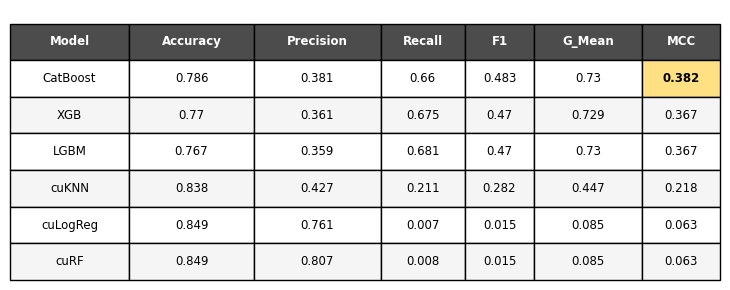

In [ ]:
tbl = baseline_results.loc[:, ["Accuracy", "Precision", "Recall",
                               "F1", "G_Mean", "MCC"]].round(3)
tbl_disp = (tbl.reset_index().rename(columns={"index": "Model"}))

fig, ax = plt.subplots(figsize=(7.4, 3))
ax.axis("off")

header_bg, header_txt = "#4c4c4c", "w"
row_even_bg, row_odd_bg = "#f5f5f5", "w"
best_bg, best_txt = "#ffe082", "k"

table = ax.table(cellText=tbl_disp.values,
                 colLabels=tbl_disp.columns,
                 bbox=[0, 0, 1, 0.95],
                 cellLoc="center", rowLoc="center")
table.auto_set_font_size(False)
table.set_fontsize(8.5)

for c in range(len(tbl_disp.columns)):
    cell = table[(0, c)]
    cell.set_facecolor(header_bg)
    cell.set_text_props(color=header_txt, weight="bold")

best_r = tbl_disp["MCC"].idxmax() + 1
mcc_c  = list(tbl_disp.columns).index("MCC")
for (r, c), cell in table.get_celld().items():
    if r == 0:
        continue
    cell.set_facecolor(row_even_bg if r % 2 == 0 else row_odd_bg)
    if r == best_r and c == mcc_c:
        cell.set_facecolor(best_bg)
        cell.set_text_props(color=best_txt, weight="bold")

for c in range(len(tbl_disp.columns)):
    table.auto_set_column_width(col=c)

plt.tight_layout()
plt.savefig(f"{FIGS_DIR}/fig8.jpg",
            bbox_inches="tight", facecolor="w", dpi=600)
plt.show()

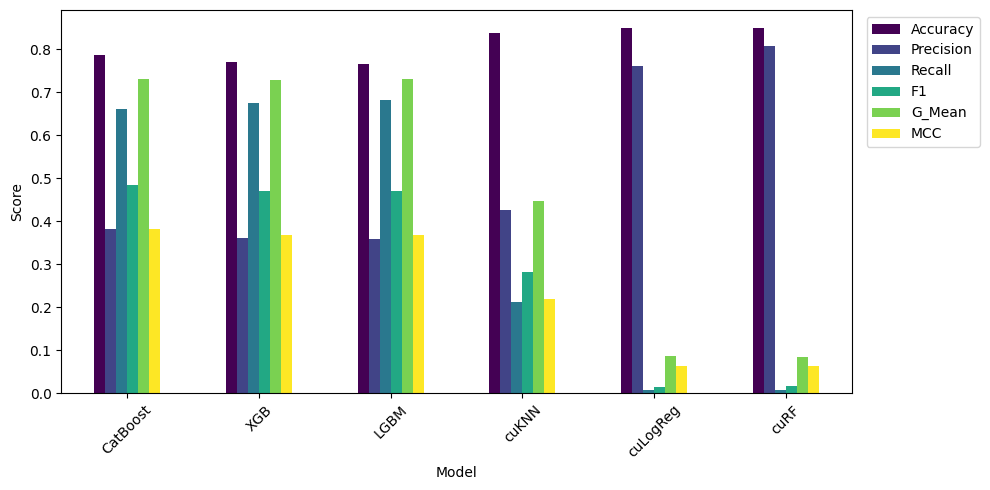

In [ ]:
order = ["Accuracy", "Precision", "Recall", "F1", "G_Mean", "MCC"]
baseline_results[order].plot(kind="bar", figsize=(10,5), cmap="viridis")
plt.ylabel("Score")
plt.xticks(rotation=45)
plt.legend(bbox_to_anchor=(1.01,1), loc="upper left")
plt.tight_layout()
plt.savefig(f"{FIGS_DIR}/fig9.jpg",
            bbox_inches="tight", facecolor="w", dpi=600)
plt.show()

In [ ]:
print(f"\n🏆  Highest MCC Baseline Model =>  {baseline_results.index[0]}")


🏆  Highest MCC Baseline Model =>  CatBoost


In [ ]:
# Now lets tune the best 3 models

mcc_scorer = make_scorer(matthews_corrcoef)

param_dists = {
    "XGB": {
        "clf__max_depth":        randint(4, 10),
        "clf__learning_rate":    loguniform(1e-2, 2e-1),
        "clf__n_estimators":     randint(300, 800),
        "clf__subsample":        uniform(0.6, 0.4)
    },
    "CatBoost": {
        "clf__depth":            randint(4, 10),
        "clf__learning_rate":    loguniform(1e-2, 2e-1),
        "clf__l2_leaf_reg":      loguniform(1, 10),
        "clf__iterations":       randint(300, 800)
    },
    "LGBM": {
        "clf__max_depth":        [-1, 6, 8, 10, 12],
        "clf__learning_rate":    loguniform(1e-2, 2e-1),
        "clf__n_estimators":     randint(300, 800),
        "clf__subsample":        uniform(0.6, 0.4),
        "clf__colsample_bytree": uniform(0.6, 0.4)
    }
}

In [ ]:
print("param_dists keys:", param_dists.keys())

param_dists keys: dict_keys(['XGB', 'CatBoost', 'LGBM'])


In [ ]:
print(models.keys())

dict_keys(['XGB', 'CatBoost', 'LGBM', 'cuRF', 'cuLogReg', 'cuKNN'])


In [ ]:
top3_models = {k: models[k] for k in ["XGB", "CatBoost", "LGBM"]}
search_results = []
best_models    = {}

In [ ]:
gkf = StratifiedGroupKFold(n_splits=3, shuffle=True, random_state=RANDOM_STATE)
cv_groups = block_lbl[train_mask]

In [ ]:
for name, base_clf in top3_models.items():
    print(f"→ tuning {name}")
    pipe = Pipeline([("pre", preproc), ("clf", base_clf)])

    rs = RandomizedSearchCV(
        pipe,
        param_distributions = param_dists[name],
        n_iter              = 30,
        scoring             = mcc_scorer,
        cv                  = list(gkf.split(X_train_raw, y_train, groups=cv_groups)),
        random_state        = RANDOM_STATE,
        n_jobs              = 1,
        verbose             = 1
    )

    rs.fit(X_train_raw, y_train, groups=cv_groups)
    best_models[name] = rs.best_estimator_

    # evaluate on held-out TEST blocks
    y_pred = rs.predict(X_test_raw)
    if hasattr(y_pred, "get"):                      # cuDF/CuPy safeguard
        y_pred = y_pred.get()
    acc, prec, rec, f1, mcc, gmean = metrics(y_test, y_pred)

    search_results.append(dict(Model      = name,
                               BestParams = rs.best_params_,
                               Accuracy   = acc,
                               Precision  = prec,
                               Recall     = rec,
                               F1         = f1,
                               MCC        = mcc,
                               G_Mean     = gmean))

tune_df = (pd.DataFrame(search_results)
           .set_index("Model")
           .sort_values("MCC", ascending=False))

print("\n=== Tuned model performance on independent TEST blocks ===")
display(tune_df[["Accuracy", "Precision", "Recall", "F1", "G_Mean", "MCC"]])

→ tuning XGB
Fitting 3 folds for each of 30 candidates, totalling 90 fits
→ tuning CatBoost
Fitting 3 folds for each of 30 candidates, totalling 90 fits
→ tuning LGBM
Fitting 3 folds for each of 30 candidates, totalling 90 fits
[LightGBM] [Info] Number of positive: 25266, number of negative: 141466
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 2867
[LightGBM] [Info] Number of data points in the train set: 166732, number of used features: 44
[LightGBM] [Info] Using GPU Device: Tesla T4, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 12 dense feature groups (1.91 MB) transferred to GPU in 0.002356 secs. 0 sparse feature groups
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.151537 -> initscore=-1.722600
[LightGBM] [Info] Start training from score -1.722600
[LightGBM] [Warning] No further splits with positive 

,Accuracy,Precision,Recall,F1,G_Mean,MCC
Model,,,,,,
XGB,0.853802,0.554558,0.454577,0.499615,0.650254,0.417805
CatBoost,0.817027,0.445198,0.567025,0.498780,0.700277,0.393099
LGBM,0.805113,0.422853,0.585941,0.491214,0.704494,0.382182


In [ ]:
print("\nBest tuned parameters:")
for m, params in tune_df["BestParams"].items():
    print(f"{m} => {params}")


Best tuned parameters:
XGB => {'clf__learning_rate': np.float64(0.16820261606177922), 'clf__max_depth': 9, 'clf__n_estimators': 541, 'clf__subsample': np.float64(0.7541666010159664)}
CatBoost => {'clf__depth': 9, 'clf__iterations': 514, 'clf__l2_leaf_reg': np.float64(3.3176782070582926), 'clf__learning_rate': np.float64(0.1780383803110714)}
LGBM => {'clf__colsample_bytree': np.float64(0.6298202574719083), 'clf__learning_rate': np.float64(0.19229567074543377), 'clf__max_depth': -1, 'clf__n_estimators': 791, 'clf__subsample': np.float64(0.7173952698872152)}


In [ ]:
tbl = tune_df.loc[:, ["Accuracy", "Precision", "Recall",
                      "F1", "G_Mean", "MCC"]].round(3)
tbl_disp = (tbl.reset_index().rename(columns={"index": "Model"}))

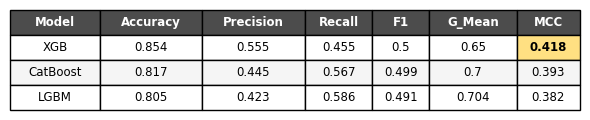

In [ ]:
n_rows       = len(tbl_disp) + 1
row_height   = 0.3
bbox_height  = n_rows * row_height
bbox_height  = min(bbox_height, 1)

fig, ax = plt.subplots(figsize=(6, 1.3))
ax.axis("off")

table = ax.table(cellText=tbl_disp.values,
                 colLabels=tbl_disp.columns,
                 bbox=[0, 1 - bbox_height, 1, bbox_height],
                 cellLoc="center", rowLoc="center")
table.auto_set_font_size(False)
table.set_fontsize(8.5)

for c in range(len(tbl_disp.columns)):
    cell = table[(0, c)]
    cell.set_facecolor(header_bg)
    cell.set_text_props(color=header_txt, weight="bold")

best_r = tbl_disp["MCC"].idxmax() + 1
for (r, c), cell in table.get_celld().items():
    if r == 0:
        continue
    cell.set_facecolor(row_even_bg if r % 2 == 0 else row_odd_bg)
    if r == best_r and c == mcc_c:
        cell.set_facecolor(best_bg)
        cell.set_text_props(color=best_txt, weight="bold")

for c in range(len(tbl_disp.columns)):
    table.auto_set_column_width(col=c)

plt.tight_layout()
plt.savefig(f"{FIGS_DIR}/fig10.jpg",
            bbox_inches="tight", facecolor="w", dpi=600)
plt.show()

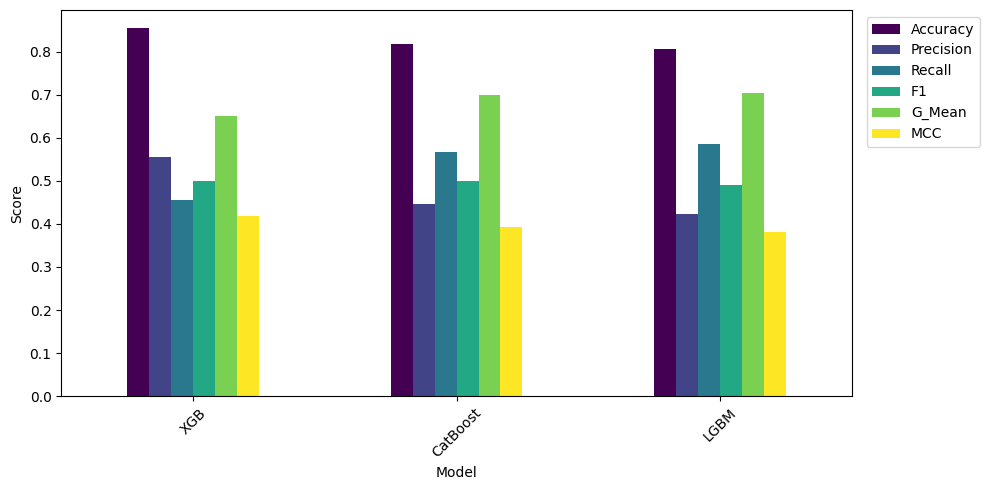


🏆  Highest MCC model =>  XGB


In [ ]:
order = ["Accuracy", "Precision", "Recall", "F1", "G_Mean", "MCC"]
tune_df[order].plot(kind="bar", figsize=(10,5), cmap="viridis")
plt.ylabel("Score")
plt.xticks(rotation=45)
plt.legend(bbox_to_anchor=(1.01,1), loc="upper left")
plt.tight_layout()
plt.savefig(f"{FIGS_DIR}/fig11.jpg",
            bbox_inches="tight", facecolor="w", dpi=600)
plt.show()

print(f"\n🏆  Highest MCC model =>  {tune_df.index[0]}")